In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import re

## Load dataframe
I have constructed a dataframe containing 1425 features. <br>
This dataframe takes up a lot of memory and it will take a long time to train models on it. <br>
It is likely that many of these features are redundant and have little informational value, so I will try to shrink down the dataset while losing as little information as possible.

In [2]:
df = pd.read_csv('./dataset_full.csv')
print(df.shape)
df.head()

(356255, 1427)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,175783.73,175783.73,219625.700,219625.700,219625.690,219625.690,1008781.200,1008781.200,4.172888e+06,4.172888e+06
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1154108.20,1154108.20,1150977.400,1150977.400,1618864.600,1618864.600,4394101.500,4394101.500,1.134881e+07,1.134881e+07
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,16071.75,16071.75,21288.465,21288.465,21288.465,21288.465,31721.895,31721.895,6.386539e+04,6.386539e+04
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,994476.70,994476.70,691786.900,691786.900,1007153.400,1007153.400,1057860.200,1057860.200,3.719995e+06,3.719995e+06
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,483756.38,825845.80,280199.700,294631.120,806127.940,835985.300,836703.400,836703.400,1.139621e+07,1.179154e+07


## Remove features with too many missing values
First of all, I will remove all features where more than 75% of rows contain missing a missing value. <br>
69 features are removed in this way.

In [3]:
missing = pd.DataFrame(df.isnull().sum())
missing['percent'] = 100 * missing / len(df)
missing_columns = list(missing.index[missing['percent'] > 75])
print(len(missing_columns))
df = df.drop(columns=missing_columns)

69


## Remove features with very high collinearity
Secondly, I will remove features with a collinearity over 90%. <br>
Since it will take forever to calculate the correlation matrix on the whole dataset, I use a sample of 20k rows, which should be a close enough proxy. <br>
614 highly collinear features are dropped from the dataset.

In [4]:
corr_matrix = df.sample(20000).corr().abs()
corr_matrix.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,1.000000,0.009628,0.006617,0.006575,0.007834,0.010166,0.008516,0.000975,0.004255,0.004860,...,0.000556,0.007417,0.001803,0.003901,0.005079,0.005827,0.001827,0.001634,0.008741,0.009830
TARGET,0.009628,1.000000,0.010943,0.032207,0.036651,0.018014,0.045729,0.038889,0.076520,0.074433,...,0.051856,0.027045,0.021764,0.014793,0.015119,0.009895,0.009080,0.007853,0.008455,0.005472
CNT_CHILDREN,0.006617,0.010943,1.000000,0.032372,0.015096,0.033761,0.010913,0.029252,0.328320,0.069025,...,0.065370,0.059271,0.041174,0.038159,0.054013,0.053468,0.024914,0.025401,0.040557,0.039797
AMT_INCOME_TOTAL,0.006575,0.032207,0.032372,1.000000,0.387563,0.469629,0.393908,0.164441,0.058423,0.043363,...,0.191857,0.205333,0.248413,0.255943,0.228728,0.228988,0.160644,0.161549,0.154948,0.151361
AMT_CREDIT,0.007834,0.036651,0.015096,0.387563,1.000000,0.769275,0.987237,0.101677,0.046414,0.098933,...,0.133516,0.126434,0.202805,0.204108,0.171505,0.166994,0.133605,0.134234,0.114987,0.109277


In [5]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,NaN,0.009628,0.006617,0.006575,0.007834,0.010166,0.008516,0.000975,0.004255,0.004860,...,0.000556,0.007417,0.001803,0.003901,0.005079,0.005827,0.001827,0.001634,0.008741,0.009830
TARGET,NaN,NaN,0.010943,0.032207,0.036651,0.018014,0.045729,0.038889,0.076520,0.074433,...,0.051856,0.027045,0.021764,0.014793,0.015119,0.009895,0.009080,0.007853,0.008455,0.005472
CNT_CHILDREN,NaN,NaN,NaN,0.032372,0.015096,0.033761,0.010913,0.029252,0.328320,0.069025,...,0.065370,0.059271,0.041174,0.038159,0.054013,0.053468,0.024914,0.025401,0.040557,0.039797
AMT_INCOME_TOTAL,NaN,NaN,NaN,NaN,0.387563,0.469629,0.393908,0.164441,0.058423,0.043363,...,0.191857,0.205333,0.248413,0.255943,0.228728,0.228988,0.160644,0.161549,0.154948,0.151361
AMT_CREDIT,NaN,NaN,NaN,NaN,NaN,0.769275,0.987237,0.101677,0.046414,0.098933,...,0.133516,0.126434,0.202805,0.204108,0.171505,0.166994,0.133605,0.134234,0.114987,0.109277


In [6]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
len(to_drop)

614

In [7]:
df = df.drop(columns=to_drop)
df.shape

(356255, 744)

## Remove features with low importance
Lastly I will remove the features with the lowest importance as given by a boosted random forest.

### Calculate feature importance in LightGBM
With 742 features, the model returns a ROC of 0.7864. A significant improvement over the initial models discussed in the first notebook. <br>
389 features are of no importance and can be safely discarded. A total of 318 features are needed to achieve 95% of the cumulative feature importances. <br>

In [8]:
X = pd.get_dummies(df[df.test==False].drop(columns = ['SK_ID_CURR', 'TARGET']))
y = df.loc[df.test==False, 'TARGET']

In [9]:
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [10]:
feature_importances = np.zeros(X.shape[1])

In [11]:
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 13)

In [13]:
model.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = 'auc', 
          callbacks = [lgb.early_stopping(100), lgb.log_evaluation(100)])

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.784779	valid_0's binary_logloss: 0.533761
[200]	valid_0's auc: 0.78577	valid_0's binary_logloss: 0.505653
Early stopping, best iteration is:
[150]	valid_0's auc: 0.786399	valid_0's binary_logloss: 0.518308


LGBMClassifier(boosting_type='goss', class_weight='balanced',
               n_estimators=10000, objective='binary')

In [14]:
feature_importances = model.feature_importances_
feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
25,EXT_SOURCE_1,153
73,credit_term,145
26,EXT_SOURCE_2,136
27,EXT_SOURCE_3,125
3,AMT_ANNUITY,84


In [15]:
len(feature_importances.loc[feature_importances.importance == 0.0,'feature'])

389

In [16]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop=True)
feature_importances['norm'] = feature_importances['importance'] / feature_importances['importance'].sum()
feature_importances['cumulative'] = np.cumsum(feature_importances['norm'])

In [17]:
feature_importances.head()

,feature,importance,norm,cumulative
0,EXT_SOURCE_1,153,0.034000,0.034000
1,credit_term,145,0.032222,0.066222
2,EXT_SOURCE_2,136,0.030222,0.096444
3,EXT_SOURCE_3,125,0.027778,0.124222
4,AMT_ANNUITY,84,0.018667,0.142889


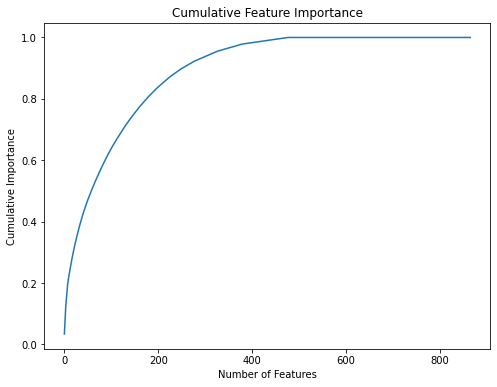

In [18]:
plt.figure(figsize = (8, 6))
plt.plot(feature_importances.index, feature_importances.cumulative)
plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
plt.title('Cumulative Feature Importance');
plt.show();

In [19]:
for i in [0.8, 0.9, 0.95]:
    print('{} features make up {}% of cumulative importance.'.format(
        len(feature_importances[feature_importances.cumulative < i]),
        i*100
    ))

175 features make up 80.0% of cumulative importance.
252 features make up 90.0% of cumulative importance.
318 features make up 95.0% of cumulative importance.


### Remove low importance features and test model
I reduce the model to the 318 most important features. <br>
The model is now significantly smaller and the accuracy drops only slightly to a ROC 0.7847.

In [20]:
keep = list(feature_importances.loc[feature_importances.cumulative < 0.95,'feature'])
X = X[keep]

In [21]:
feature_importances = np.zeros(X.shape[1])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 13)

In [23]:
model.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = 'auc', 
          callbacks = [lgb.early_stopping(100), lgb.log_evaluation(100)])

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.783234	valid_0's binary_logloss: 0.53465
[200]	valid_0's auc: 0.784133	valid_0's binary_logloss: 0.506797
Early stopping, best iteration is:
[155]	valid_0's auc: 0.784706	valid_0's binary_logloss: 0.518065


LGBMClassifier(boosting_type='goss', class_weight='balanced',
               n_estimators=10000, objective='binary')